![](figs/se_03.png)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CLDiego/uom_fse_dl_workshop/blob/main/SE03_CA_Physics_informed_neural_networks.ipynb)
# Workshop Instructions
***
- <img src="figs/icons/write.svg" width="20"/> Follow along by typing the code yourself - this helps with learning!
- <img src="figs/icons/code.svg" width="20"/> Code cells marked as "Exercise" are for you to complete
- <img src="figs/icons/reminder.svg" width="20"/> Look for hints if you get stuck
- <img src="figs/icons/success.svg" width="20" /> Compare your solution with the provided answers
- <img src="figs/icons/list.svg" width="20" /> Don't worry if you make mistakes - debugging is part of learning!

In [1]:
# !git clone https://github.com/CLDiego/uom_fse_dl_workshop.git
# %cd uom_fse_dl_workshop
# !pip install -r requirements.txt

In [2]:
import torch
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import utils
from pathlib import Path
import sys

helper_utils = Path.cwd().parent
sys.path.append(str(helper_utils))


Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 1.0.1+2199918


# 1. Introduction to PINNs
***
> <img src="figs/icons/write.svg" width="20"/> **Definition**: Physics-Informed Neural Networks (PINNs) are neural networks that are trained to solve supervised learning tasks while respecting physical laws described by partial differential equations.

PINNs combine two major concepts:

| Component | Description | Role |
|-----------|-------------|------|
| **Neural Networks** | Deep learning models that can approximate complex functions | Learn patterns from data |
| **Physical Laws** | Mathematical equations describing system behavior | Enforce physical constraints |

## 1.1 Why PINNs?
***
Traditional numerical methods for solving PDEs face several challenges:

| Challenge | Traditional Methods | PINN Solution |
|-----------|---------------------|---------------|
| **Computational Cost** | High for complex geometries | Efficient once trained |
| **Mesh Requirements** | Need fine meshes | Meshless approach |
| **Limited Data** | Require complete boundary conditions | Can work with sparse data |
| **High Dimensions** | Suffer from curse of dimensionality | Better scaling with dimensions |

## 1.2 PINN Architecture
***
In this workshop we are going to use a Physics-Informed Neural Network (PINN) to solve the Navier-Stokes equations. The PINN model is a neural network that is trained to satisfy the Navier-Stokes equations, as well as the boundary conditions of the problem. The PINN model consists of the following components:

| Component | Description |
|----------|-------------|
| Neural Network | A feedforward neural network that takes the input features (e.g., coordinates, time) and outputs the predicted values (e.g., velocity, pressure). |
| Loss Function | A combination of the mean squared error (MSE) loss and the physics loss, which is based on the Navier-Stokes equations. |
| Optimiser | An optimisation algorithm (e.g., Adam, SGD) that updates the weights and biases of the neural network during training. |
***
<figure style="background-color: white; border-radius: 10px; padding: 30px; text-align: center; margin: 0 auto;">
    <img src="figs\pinn.png" alt="PINN model" align="center" style="width: 45%; height: auto; margin: 0 auto;">
</figure>

For the connected layers we are going to use the following activation functions:
| Layer | Activation Function |
|-------|---------------------|
| Input Layer | Tanh |
| Hidden Layers | Tanh |
| Output Layer | Tanh |

The choice of activation function for the output layer is important, as it can affect the range of the output values. In this case, we are using Tanh to ensure that the output values are in the range [-1, 1]. This is important for the PINN model, as we want to ensure that the predicted values are in the same range as the input features.


The PINN architecture consists of:
| Component | Purpose | Implementation |
|-----------|---------|----------------|
| **Input Layer** | Takes spatial/temporal coordinates | $(x, y, t)$ coordinates |
| **Hidden Layers** | Learn the underlying patterns | Multiple fully connected layers |
| **Output Layer** | Predicts physical quantities | Velocity and pressure fields |
| **Physics Loss** | Enforces PDE constraints | Automatic differentiation |

# 2. Case Study: Navier-Stokes Equations
***
> <img src="figs/icons/write.svg" width="20"/> **Definition**: The Navier-Stokes equations are partial differential equations that describe the motion of viscous fluid substances, forming the basis of fluid dynamics.

## 2.1 Problem Description
***
We will study flow around a cylinder, a classic problem in fluid dynamics:

| Parameter | Description | Value |
|-----------|-------------|--------|
| **Domain** | Spatial region | $[-15,25] × [-8,8]$ |
| **Reynolds Number** | Ratio of inertial to viscous forces | $Re=100$ |
| **Inlet Velocity** | Uniform free stream | $U_∞=1$ |
| **Kinematic Viscosity** | Fluid property | $ν=0.01$ |

## 2.2 Governing Equations
***
The incompressible Navier-Stokes equations in 2D are:

$$
\begin{align*}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} &= -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \\
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} &= -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) \\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} &= 0
\end{align*}
$$

where:
- $(u,v)$ are velocity components
- $p$ is pressure
- $ρ$ is density
- $ν$ is kinematic viscosity

## Pre-processing the data
***
In this notebook we are going to explore a realistic scenario of incompressible fluid flow as described by the ubiquitous Navier-Stokes equations. Navier-Stokes equations describe the physics of many phenomena of scientific and engineering. Often, the Navier-Stokes equations are solved using numerical methods, such as finite element or finite volume methods. However, these methods can be computationally expensive and time-consuming, especially for complex geometries and boundary conditions.
In this workshop, we will use a dataset of incompressible fluid flow around a cylinder. The dataset is generated using a finite volume method and contains the velocity and pressure fields of the fluid flow. The dataset consists of the following variables:

| Variable | Description |
|----------|-------------|
| u        | x-component of velocity |
| v        | y-component of velocity |
| p        | pressure |
| t        | time |

The dataset is generated usign the spectral/hp-element solver NekTar. The solution domain is discretised in space by a tessellation consisting of 412 triangular elements. It is assumed a uniform free stream velocity profile imposed at the left boundary, a zero pressure outflow condition imposed at the right boundary located 25 diameters downstream of the cylinder, and periodicity for the top and bottom boundaries of the [−15, 25] × [−8, 8] domain.

For this problem, we want to predict the Convective term $\lambda_1$, the viscous term $\lambda_2$, as well as a reconstruction of the pressure field $p$.


In [3]:
data_path = Path(Path.cwd(), 'datasets')
dataset_path = utils.data.download_dataset('cylinder',
                                   dest_path=data_path,
                                   extract=False,
                                   remove_compressed=False)


Downloading:
Cylinder dataset for predicting the drag coefficient of a cylinder in a flow field
> Authors: Maziar Raissi1, Paris Perdikaris, George Em Karniadakis
> Year: 2017
> Website: https://arxiv.org/pdf/1711.10566.pdf

File already exists


In [4]:
data = scipy.io.loadmat(dataset_path)
u_star = data['U_star'] # velocity n x 2 x time
p_star = data['p_star'] # pressure n x time
x_star = data['X_star'] # coordinates n x 2
time = data['t'] # time n x 1

print(f'We have {u_star.shape[0]} points in space, {u_star.shape[1]} dimensions and {u_star.shape[2]} time steps.')

We have 5000 points in space, 2 dimensions and 200 time steps.


In [5]:
fig, _ = utils.plotting.wake_cylinder_interactive(x_star, u_star, p_star, time)

interactive(children=(IntSlider(value=0, description='Time Step', max=199), Output()), _dom_classes=('widget-i…

Output()

TypeError: cannot unpack non-iterable NoneType object

### Training, Validation, and Test Sets
***
As you can see in the image above, the simulation has been cropped to a smaller domain that does not include the cylinder. Thus, with this dataset we are only using 1% of the total data for training. This is to highlight the ability of PINNs to learn from limited data. In practice, you would typically use a larger portion of the dataset for training. Thus, we are not going to split the dataset into training, validation, and test sets. Instead, we will use the entire dataset for training and testing. This is a common practice in PINNs, where the model is trained on a small portion of the data and then tested on the entire dataset.

In [5]:
N, T = x_star.shape[0], time.shape[0] # number of points in space and time

# Create coordinate grids 
x_flat = x_star[:, 0]  # Extract x coordinates
y_flat = x_star[:, 1]  # Extract y coordinates
t_flat = time.flatten() # Flatten time array

# Create meshgrid-like structures for visualization
x_coords = np.tile(x_flat[:, np.newaxis], (1, T))  # Repeat x for each timestep
y_coords = np.tile(y_flat[:, np.newaxis], (1, T))  # Repeat y for each timestep
time_coords = np.tile(t_flat, (N, 1))              # Repeat time for each spatial point

# Extract velocity and pressure data
u_vals = u_star[:, 0, :]  # Extract u velocity
v_vals = u_star[:, 1, :]  # Extract v velocity
p_vals = p_star[:, :]     # Extract pressure

# Flatten into NT x 1 arrays
x = x_coords.flatten()[:, np.newaxis]
y = y_coords.flatten()[:, np.newaxis]
t = time_coords.flatten()[:, np.newaxis]
u = u_vals.flatten()[:, np.newaxis]
v = v_vals.flatten()[:, np.newaxis]
p = p_vals.flatten()[:, np.newaxis]

idx = np.random.choice(N*T, N, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]

### Normalisation
***
For PINNs, the features cannot be normalised in the same way as in traditional machine learning. Standard normalization in PINNs is tricky because physical equations must remain consistent with the scaled variables. The normalisation should be applied to the loss function considering the physics of the problem. This is a more complex process and requires a deeper understanding of the physical equations involved. In this workshop, we will not cover this topic in detail, but it is important to keep in mind that normalisation in PINNs is not as straightforward as in traditional machine learning.

In [6]:
# Preparing the data as tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

t_train = torch.tensor(t_train, dtype=torch.float32)
u_train = torch.tensor(u_train, dtype=torch.float32)
v_train = torch.tensor(v_train, dtype=torch.float32)


In [ ]:
# Exercise 2: Model Creation with Weight Initialization 🎯
class CylinderPINN(torch.nn.Module):
    def __init__(self, hidden_size=20, num_layers=9):
        super().__init__()
        self.nu = 0.01  # kinematic viscosity
        
        # Neural network architecture
        layers = []
        # Input layer: x, y, t
        input_layer = torch.nn.Linear(3, hidden_size)
        torch.nn.init.xavier_normal_(input_layer.weight)
        torch.nn.init.zeros_(input_layer.bias)
        layers.append(input_layer)
        layers.append(torch.nn.Tanh())
        
        # Hidden layers
        for _ in range(num_layers - 1):
            hidden_layer = torch.nn.Linear(hidden_size, hidden_size)
            torch.nn.init.xavier_normal_(hidden_layer.weight)
            torch.nn.init.zeros_(hidden_layer.bias)
            layers.append(hidden_layer)
            layers.append(torch.nn.Tanh())
        
        # Output layer: ψ (stream function), p (pressure)
        output_layer = torch.nn.Linear(hidden_size, 2)
        torch.nn.init.xavier_normal_(output_layer.weight)
        torch.nn.init.zeros_(output_layer.bias)
        layers.append(output_layer)
        
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x, y, t):
        # Combine inputs
        inputs = torch.cat([x, y, t], dim=1)
        # Get stream function (ψ) and pressure (p)
        outputs = self.net(inputs)
        psi, p = outputs[:, 0:1], outputs[:, 1:2]
        
        # Calculate velocities using automatic differentiation
        u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        v = -torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        
        return u, v, p

model = CylinderPINN(hidden_size=20, num_layers=9)

## PINN Optimiser
***
When training a PINN model, the choice of optimiser is crucial for achieving good performance. While the Adam optimiser is a popular choice for many deep learning tasks, it may not always be the best choice for PINNs. A better choice for PINNs is the L-BFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) optimiser, which is a quasi-Newton method that approximates the inverse Hessian matrix. L-BFGS is particularly well-suited for PINNs because it can efficiently handle the large number of parameters in the model and can converge faster than Adam in some cases.

However, in order to use L-BFGS, we need to ensure that the loss function is differentiable with respect to the model parameters. This is important because L-BFGS uses second-order information (the Hessian) to update the model parameters. If the loss function is not differentiable, L-BFGS may not converge or may converge to a suboptimal solution. 

To use the L-BFGS optimiser in PyTorch, we need to define a closure function that computes the loss and gradients. The closure function is called by the L-BFGS optimiser to compute the loss and gradients at each iteration. The closure function should return the loss value and the gradients of the model parameters with respect to the loss.
***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 2**: Using L-BFGS Optimiser

```python
import torch.optim as optim

# Define the model
model = PINNModel()
# Define the loss function
loss_function = PINNLoss()
# Define the optimizer
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
# Define the closure function
def closure():
    optimizer.zero_grad()
    loss = loss_function(model)
    loss.backward()
    return loss

# Training loop
for epoch in range(num_epochs):
    optimizer.step(closure)
```

## PINN Loss Function
***
The loss function for the PINN model is a combination of the mean squared error (MSE) loss and the physics loss, which is based on the Navier-Stokes equations. The total loss function can be expressed as:
$$
L_{total} = L_{MSE} + \lambda_1 L_{convective} + \lambda_2 L_{viscous} + \lambda_3 L_{pressure}
$$
where:
- $L_{MSE}$ is the mean squared error loss between the predicted and true values
- $L_{convective}$ is the loss associated with the convective term of the Navier-Stokes equations
- $L_{viscous}$ is the loss associated with the viscous term of the Navier-Stokes equations
- $L_{pressure}$ is the loss associated with the pressure term of the Navier-Stokes equations
- $\lambda_1$, $\lambda_2$, and $\lambda_3$ are the weights for each term in the loss function. These weights can be adjusted to balance the contributions of each term to the total loss. The choice of these weights is important, as they can significantly affect the performance of the PINN model.

We can calculate the residuals of the Navier-Stokes equations using the following equations:
$$
\begin{align*}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} &= -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \\
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} &= -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) \\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} &= 0
\end{align*}
$$
where:
- $u$ and $v$ are the x and y components of the velocity field, respectively
- $p$ is the pressure field
- $\rho$ is the density of the fluid
- $\nu$ is the kinematic viscosity of the fluid
- $t$ is the time
- $x$ and $y$ are the spatial coordinates

### Automatic Differentiation in PINNs
***
One of the key features of PINNs is their ability to automatically compute derivatives using automatic differentiation (autograd). This is crucial for enforcing physical constraints defined by PDEs.

#### How Automatic Differentiation Works
When we use `torch.autograd.grad()`, PyTorch computes derivatives through the computational graph:

```python
u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
```

| Parameter | Purpose | Description |
|-----------|---------|-------------|
| `u` | Target tensor | The output we want to differentiate |
| `t` | Source tensor | The variable we're differentiating with respect to |
| `grad_outputs` | Scaling factor | Usually ones, for direct gradient computation |
| `create_graph` | Enable higher derivatives | Needed for second derivatives |

#### Computing PDE Terms
For the Navier-Stokes equations, we need several derivatives:

1. **First-order time derivatives**:
   ```python
   u_t = ∂u/∂t  # Temporal derivative
   ```

2. **First-order spatial derivatives**:
   ```python
   u_x = ∂u/∂x  # Spatial derivative in x
   u_y = ∂u/∂y  # Spatial derivative in y
   ```

3. **Second-order spatial derivatives**:
   ```python
   u_xx = ∂²u/∂x²  # Second derivative in x
   u_yy = ∂²u/∂y²  # Second derivative in y
   ```

### Computing Physical Residuals
***
The PINN enforces the Navier-Stokes equations by minimizing their residuals. Let's break down how each term is computed:

1. **Convective Terms**:
   ```python
   convective_x = u * u_x + v * u_y  # Convection in x-direction
   convective_y = u * v_x + v * v_y  # Convection in y-direction
   ```

2. **Viscous Terms**:
   ```python
   viscous_x = model.nu * (u_xx + u_yy)  # Viscous forces in x
   viscous_y = model.nu * (v_xx + v_yy)  # Viscous forces in y
   ```

3. **Pressure Terms**:
   ```python
   pressure_x = p_x  # Pressure gradient in x
   pressure_y = p_y  # Pressure gradient in y
   ```

### Loss Function Components
***
The total loss combines data and physics losses:

1. **Data Loss**:
   ```python
   data_loss = mse_loss(u_pred, u_true) + mse_loss(v_pred, v_true)
   ```

2. **Physics Loss**:
   ```python
   f = u_t + convective_x + pressure_x - viscous_x
   g = v_t + convective_y + pressure_y - viscous_y
   physics_loss = mse_loss(f, 0) + mse_loss(g, 0)
   ```

3. **Total Loss**:
   ```python
   total_loss = data_loss + physics_loss
   ```

The physics loss ensures that the solution satisfies the Navier-Stokes equations, while the data loss ensures the solution matches known data points. This dual optimization approach is what makes PINNs powerful for solving PDEs.

In [10]:
# Exercise 4: Optimizer and Loss Function Selection 🎯
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def compute_pde_loss(model, x, y, t):
    u, v, p = model(x, y, t)
    
    # Calculate all required derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
    
    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    
    # Navier-Stokes equations residuals
    f = u_t + u * u_x + v * u_y + p_x - model.nu * (u_xx + u_yy)
    g = v_t + u * v_x + v * v_y + p_y - model.nu * (v_xx + v_yy)
    
    return f, g

## Step 8 and 9: Create Training Loop and Fit Model
***
The training loop implements the key steps for training a neural network model:

| Step | Description | Code Example |
|------|-------------|--------------|
| 1. Forward Pass | Pass input data through model to generate predictions | `predictions = model(inputs)` |  
| 2. Loss Computation | Calculate loss between predictions and targets | `loss = criterion(predictions, targets)` |
| 3. Backward Pass | Compute gradients through backpropagation | `loss.backward()` |
| 4. Parameter Updates | Update model parameters using optimizer | `optimizer.step()` |
| 5. Gradient Reset | Zero out gradients for next iteration | `optimizer.zero_grad()` |

The next step is to fit the model using the training data. The model is trained for a specified number of epochs, and the training and validation loss is monitored during training. The number of epochs is a hyperparameter that determines how many times the model will be trained on the entire training dataset.

***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 3**: Training Loop Structure

```python
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    # 1. Forward Pass
    predictions = model(inputs)
    
    # 2. Loss Computation
    loss = criterion(predictions, targets)
    
    # 3. Backward Pass
    loss.backward()
    
    # 4. Parameter Updates
    optimizer.step()
    
    # 5. Gradient Reset
    optimizer.zero_grad()



Training on: cuda


Training PINN: 100%|██████████| 10000/10000 [27:56<00:00,  5.96it/s, data_loss=0.0238, physics_loss=0.0056, total_loss=0.0293]


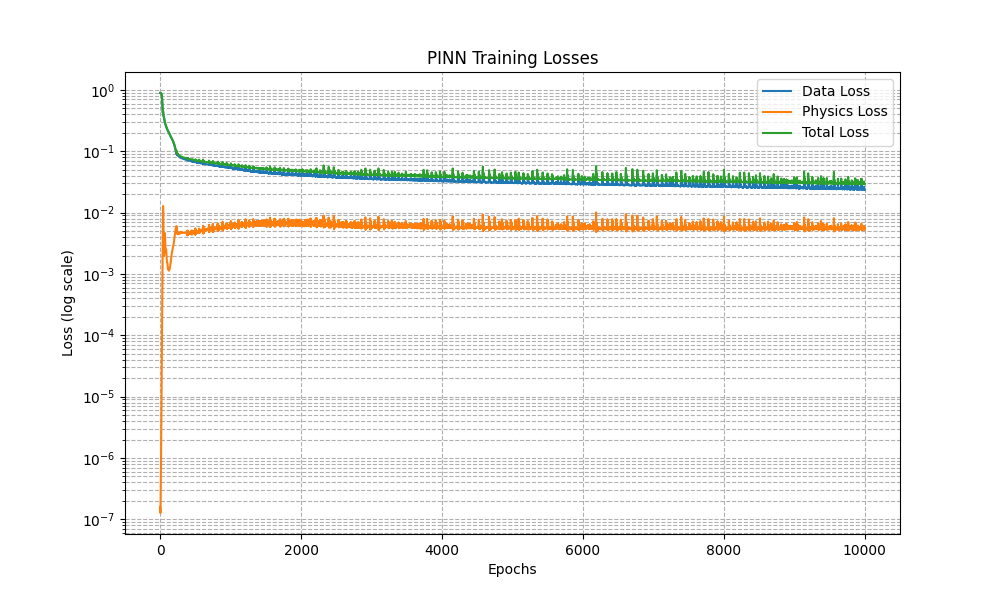

In [23]:
def train_pinn(model, data, epochs=20000, lr=0.001):
    x, y, t, u_true, v_true = data
    
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on: {device}")
    
    # Move model to device
    model = model.to(device)
    
    # Check if inputs are already tensors, if not convert them
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32)
    if not isinstance(t, torch.Tensor):
        t = torch.tensor(t, dtype=torch.float32)
    if not isinstance(u_true, torch.Tensor):
        u_true = torch.tensor(u_true, dtype=torch.float32)
    if not isinstance(v_true, torch.Tensor):
        v_true = torch.tensor(v_true, dtype=torch.float32)
        
    # Move tensors to device
    x = x.to(device)
    y = y.to(device)
    t = t.to(device)
    u_true = u_true.to(device)
    v_true = v_true.to(device)
    
    # Set requires_grad=True for inputs to compute gradients
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = torch.nn.MSELoss()
    
    # Use tqdm for the progress bar
    pbar = tqdm(range(epochs), desc="Training PINN")
    
    # Lists to store losses for plotting
    data_losses = []
    physics_losses = []
    total_losses = []
    
    for epoch in pbar:
        optimizer.zero_grad()
        
        # Data loss
        u_pred, v_pred, _ = model(x, y, t)
        data_loss = mse_loss(u_pred, u_true) + mse_loss(v_pred, v_true)
        
        # Physics loss
        f, g = compute_pde_loss(model, x, y, t)
        physics_loss = mse_loss(f, torch.zeros_like(f)) + mse_loss(g, torch.zeros_like(g))
        
        # Total loss
        total_loss = data_loss + physics_loss
        
        # Store losses
        data_losses.append(data_loss.item())
        physics_losses.append(physics_loss.item())
        total_losses.append(total_loss.item())
        
        total_loss.backward()
        optimizer.step()
        
        # Update the progress bar with current losses
        pbar.set_postfix({
            'data_loss': f'{data_loss.item():.4f}',
            'physics_loss': f'{physics_loss.item():.4f}',
            'total_loss': f'{total_loss.item():.4f}'
        })
        
    # Plot the losses
    plt.figure(figsize=(10, 6))
    plt.semilogy(data_losses, label='Data Loss')
    plt.semilogy(physics_losses, label='Physics Loss')
    plt.semilogy(total_losses, label='Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('PINN Training Losses')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()
    
    return model

# Train the model
model = CylinderPINN(hidden_size=20, num_layers=9)
trained_model = train_pinn(model, (x_train, y_train, t_train, u_train, v_train), epochs=10000, lr=0.001)


In [24]:
# save the model
torch.save(trained_model.state_dict(), 'cylinder_pinn_model.pth')


## Step 10: Evaluate Model
***
The next step is to evaluate the model using the validation and test data. The model is evaluated on the validation set during training to monitor its performance and prevent overfitting. 

Since we are training a model with MSE loss, we can also plot the predicted output against the actual output to see how well the model is performing. The predicted output should be close to the actual output, and the points should be clustered around the diagonal line. If the points are scattered far from the diagonal line, it indicates that the model is not performing well.

We can also compute the R-squared value to quantify the performance of the model. The R-squared value is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The R-squared value ranges from 0 to 1, where 0 indicates that the model does not explain any of the variance in the data, and 1 indicates that the model explains all of the variance in the data.

For this step we are going to use the test set to evaluate the model. 

***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 3**: Evaluate Model

```python
# Set model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass through the model
    predictions = model(inputs)

    # Compute loss
    loss = criterion(predictions, targets)
```

interactive(children=(IntSlider(value=0, description='Time Step', max=199), Output()), _dom_classes=('widget-i…

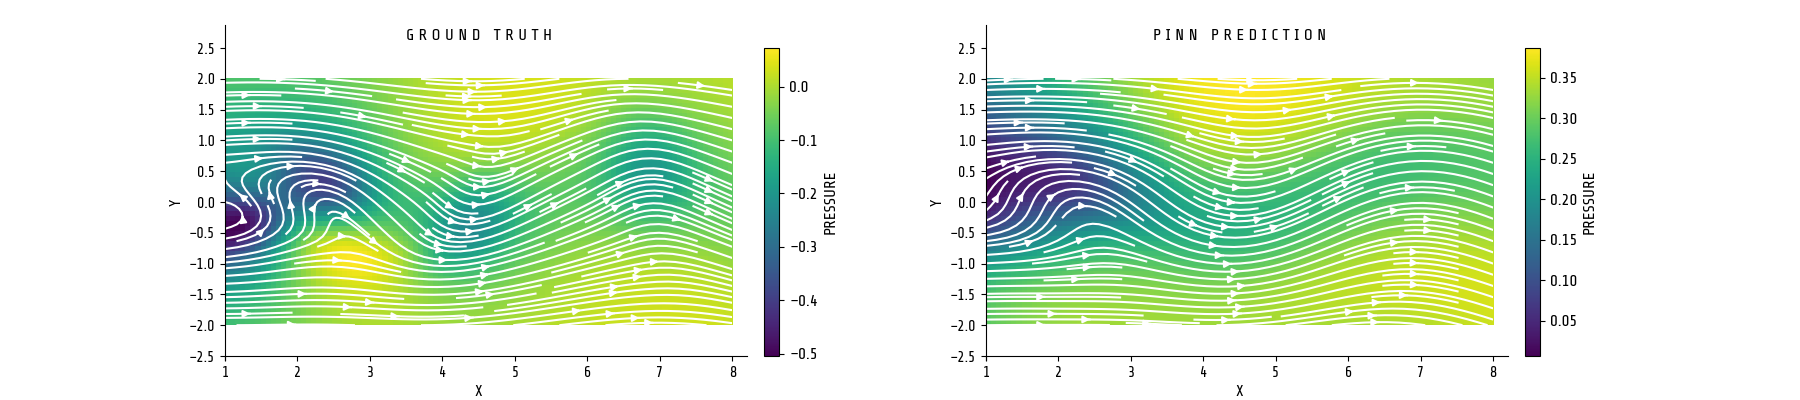

In [14]:
# Get predictions from model
import utils.plotting

# Load the model
model = CylinderPINN(hidden_size=20, num_layers=9)
model.load_state_dict(torch.load('cylinder_pinn_model.pth'))

model.eval()
model.to('cpu')
with torch.no_grad():
    u_pred = []
    v_pred = []
    p_pred = []
    
    for t_idx in range(time.shape[0]):
        # Create input tensors with requires_grad=True
        x_tensor = torch.FloatTensor(x_star[:,0]).view(-1, 1).requires_grad_(True)
        y_tensor = torch.FloatTensor(x_star[:,1]).view(-1, 1).requires_grad_(True)
        t_tensor = torch.full_like(x_tensor, time[t_idx,0]).requires_grad_(True)
        
        # Get predictions - temporarily enable gradients
        with torch.enable_grad():
            u_t, v_t, p_t = model(x_tensor, y_tensor, t_tensor)
        
        # Store predictions
        u_pred.append(u_t.detach().cpu().numpy())
        v_pred.append(v_t.detach().cpu().numpy())
        p_pred.append(p_t.detach().cpu().numpy())
    
    # Convert to arrays and reshape
    u_pred = np.stack(u_pred, axis=1)  # Shape: (N, T)
    v_pred = np.stack(v_pred, axis=1)  # Shape: (N, T)
    p_pred = np.stack(p_pred, axis=1)  # Shape: (N, T)

# Reshape ground truth data
u_true = u_star[:, 0, :]  # Shape: (N, T)
v_true = u_star[:, 1, :]  # Shape: (N, T)
p_true = p_star  # Shape: (N, T)

# Create visualization
fig, (ax1, ax2) = utils.plotting.visualize_flow_comparison(
    x_star, u_true, v_true, p_true,
    u_pred, v_pred, p_pred, time,
    figsize=(18, 4), 
)